# RiboSeq analysis

This code was originally written by Manuel Göpferich and concatenated into the current (condensed) version by Jooa.

# Packages

In [1]:
require(dplyr)
require(tibble)
require(ggplot2)
require(msigdbr)
require(TxDb.Mmusculus.UCSC.mm10.ensGene)
require(GenomicAlignments)
require(BSgenome)
require(BSgenome.Mmusculus.UCSC.mm10)
require(tidyverse)
require(DESeq2)
require(gridExtra)
require(readr)
require(ggrepel)
require(biomaRt)
require(clusterProfiler)
require(AnnotationDbi)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tibble

Loading required package: ggplot2

Loading required package: msigdbr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘msigdbr’”
Loading required package: TxDb.Mmusculus.UCSC.mm10.ensGene

Loading required package: GenomicFeatures

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine,

In [2]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=200)

# Data

## How to acquire this data

### Download data (suggested)

To get the input files download them from GEO (GSE193465) or this repository

### Running mapping and quantification

You can also create these files yourself, for that see `00-quantify_reads.ipynb`

## Load data

In [3]:
symbolsCDS <- read.csv("data/symbolsCDS.csv.gz") %>% 
    deframe
top_mrna <- read_lines('data/knownTOPmRNAs_BerndFischer.txt')

In [4]:
totalGenecounts_2h <- read.csv("data/totalGenecounts_2h.csv.gz", row.names=1)
ribobCDScounts_2h <- read.csv("data/ribobCDScounts_2h.csv.gz", row.names=1)

In [5]:
totalGenecounts <- read.csv("data/totalGenecounts.csv.gz", row.names=1)
ribobCDScounts <- read.csv("data/ribobCDScounts.csv.gz", row.names=1)

# Figures

## Figure 2C (Translational Efficiency after 2h IFN)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


[1] 119

[1] 227

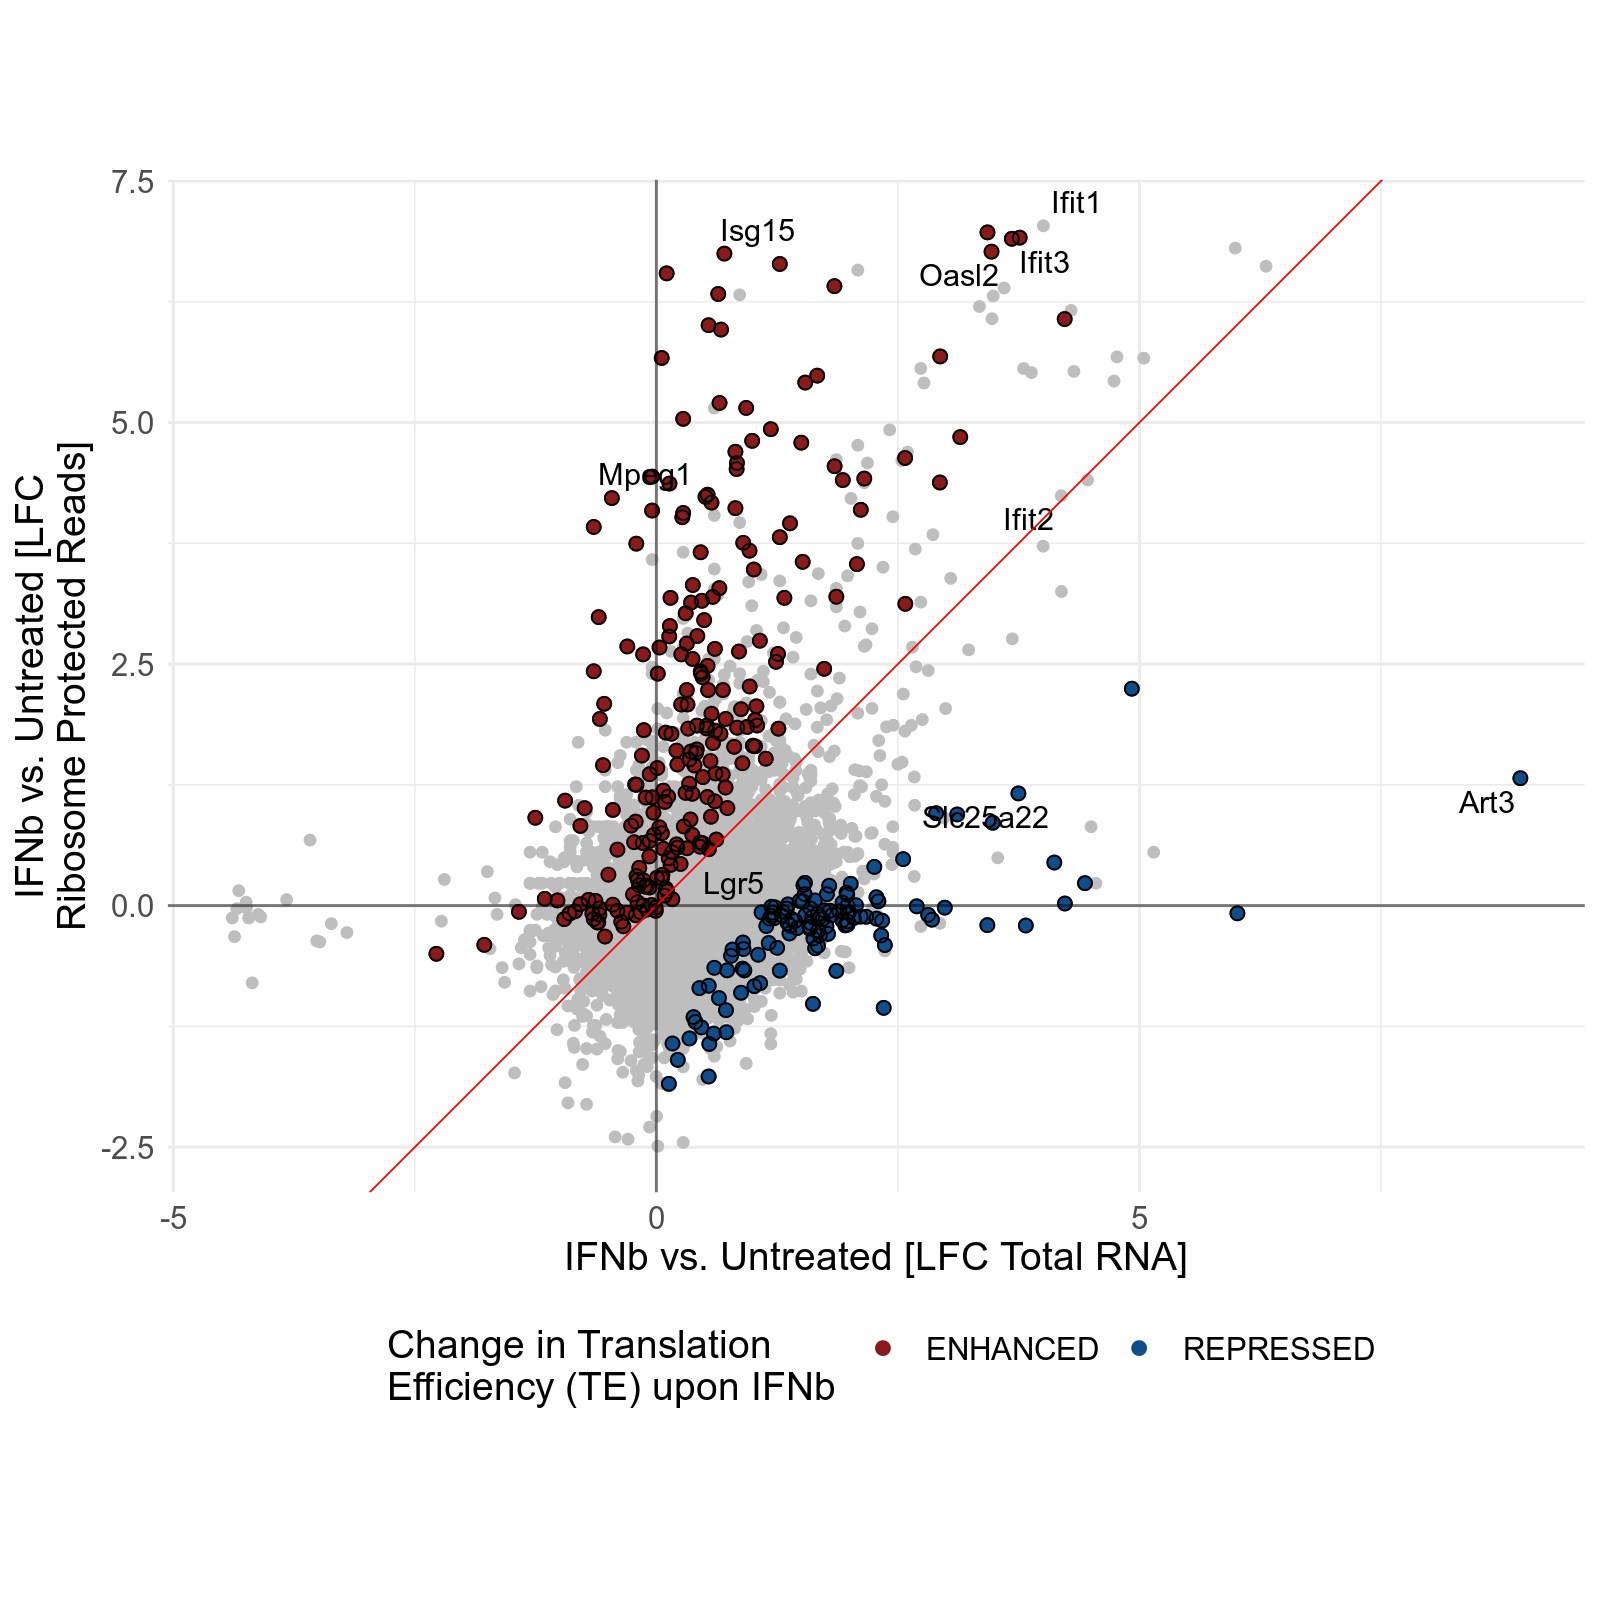

In [6]:
treatment  <- factor(rep(c('IFNb', 'untreated'), each = 4), levels = c('untreated', 'IFNb') )
replicates <- as.factor(rep(as.character(1:4), times = 2))

#identical(names(symbolsCDS), rownames(ribobCDScounts_2h) )

foot <- as_tibble(log2(ribobCDScounts_2h + 1))
colnames(foot) <- paste0(treatment, '_', replicates)
total <- as_tibble(log2(totalGenecounts_2h + 1))
colnames(total) <- paste0(treatment, '_', replicates)

total_sub     <- totalGenecounts_2h[names(symbolsCDS), ]
both_detected <- (rowSums(ribobCDScounts_2h) > 0)  & (rowSums(total_sub) > 0) # be stricter with threshold
both_detected['ENSMUSG00000074637'] <- TRUE 
assayCount_2h    <- cbind(ribobCDScounts_2h[both_detected, ], (total_sub[both_detected, ])) 

total_ifnb <- rowMeans(total_sub[both_detected, 1:4])
total_untr <- rowMeans(total_sub[both_detected, 5:8])
#toCDS_ifnb <- rowMeans( totalCDScounts[names(both_detected)[both_detected], 1:4]  )
#toCDS_untr <- rowMeans( totalCDScounts[names(both_detected)[both_detected], 5:8]  )
ribob_ifnb <- rowMeans(ribobCDScounts_2h[both_detected, 1:4])
ribob_untr <- rowMeans(ribobCDScounts_2h[both_detected, 5:8])

dds2_2h <- DESeqDataSetFromMatrix(
    countData = assayCount_2h,
    colData = tibble(assay = rep(c('Footprints', 'Total_RNA'), each = 8), treatment = rep(treatment, 2)),
    design = ~ assay + treatment + assay:treatment
)

dds2_2h <- DESeq(dds2_2h, reduced = ~ assay + treatment, test = 'LRT', quiet = TRUE, fitType = 'local')
res2 <- results(dds2_2h)@listData 
dwn  <- which(res2$padj < .1 & res2$log2FoldChange > 0) 
upr  <- which(res2$padj < .1 & res2$log2FoldChange < 0) 
te_mode <- rep('n.s.', length(res2$pvalue) )
te_mode[dwn] <- 'REPRESSED'
te_mode[upr] <- 'ENHANCED'

df_ <- tibble( Footprints_Untreated = ribob_untr + 1,
               Footprints_IFNb      = ribob_ifnb + 1,
               Total_RNA_Untreated  = total_untr + 1,
               Total_RNA_IFNb       = total_ifnb + 1
               #TE_Mode              = te_mode
               )
df_ <- apply(df_, 1, function(x, y){ x/y }, y = colSums(df_)/mean(colSums(df_)) ) %>% t() %>% as.tibble()
df_ <- cbind(df_, TE_Mode = te_mode)
length(dwn)
length(upr)
ifn_te_14h_down <- names(symbolsCDS)[both_detected][dwn]
ifn_te_14h_up <- names(symbolsCDS)[both_detected][upr]
df__ <- cbind(df_, Symbol = symbolsCDS[both_detected], ENSG = names(symbolsCDS)[both_detected] ) %>% as_tibble()
#df__
df_$Gene <- symbolsCDS[both_detected]

gg_te_scat <-  ggplot( filter(df_, TE_Mode == 'n.s.' ), aes(
  x= log2(Total_RNA_IFNb/Total_RNA_Untreated),
  y= log2(Footprints_IFNb/Footprints_Untreated),
  label = Gene
  )) + geom_point(size = 1.5, colour = 'grey') +
  geom_point(data = filter(df_, TE_Mode != 'n.s.' ), aes(colour = TE_Mode), size = 2 ) +
  geom_point(data = filter(df_, TE_Mode != 'n.s.' ), color = 'black', shape = 1, size = 2 ) +
  geom_text_repel(data = filter(df_, Gene %in% c('Oasl2', 'Ifit2', 'Ifit1', 'Ifit3', 'Mpeg1', 'Isg15', 'Lgr5', 'Slc25a22', 'Art3') )  ) +
  #geom_abline(slope = 1, intercept = 0) +
  theme_minimal() +
  scale_colour_manual(values = c('firebrick4', 'dodgerblue4')) +
  geom_abline( slope = 1, intercept =  0, size = .3, color = 'red') +
  geom_hline(yintercept = 0, alpha = 0.5) +
  geom_vline(xintercept = 0, alpha = 0.5) +
  theme(legend.position = 'bottom', text = element_text(size = 14)) +
  labs(x = 'TE(untreated)', y = 'TE(IFNb treated)') +
  coord_equal() +
  labs(x = 'IFNb vs. Untreated [LFC Total RNA]',
       y = 'IFNb vs. Untreated [LFC\nRibosome Protected Reads]',
       color = 'Change in Translation\nEfficiency (TE) upon IFNb'
       )
gg_te_scat

## Figure 2D (Translational Efficiency after 14h IFN)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


[1] 915

[1] 786

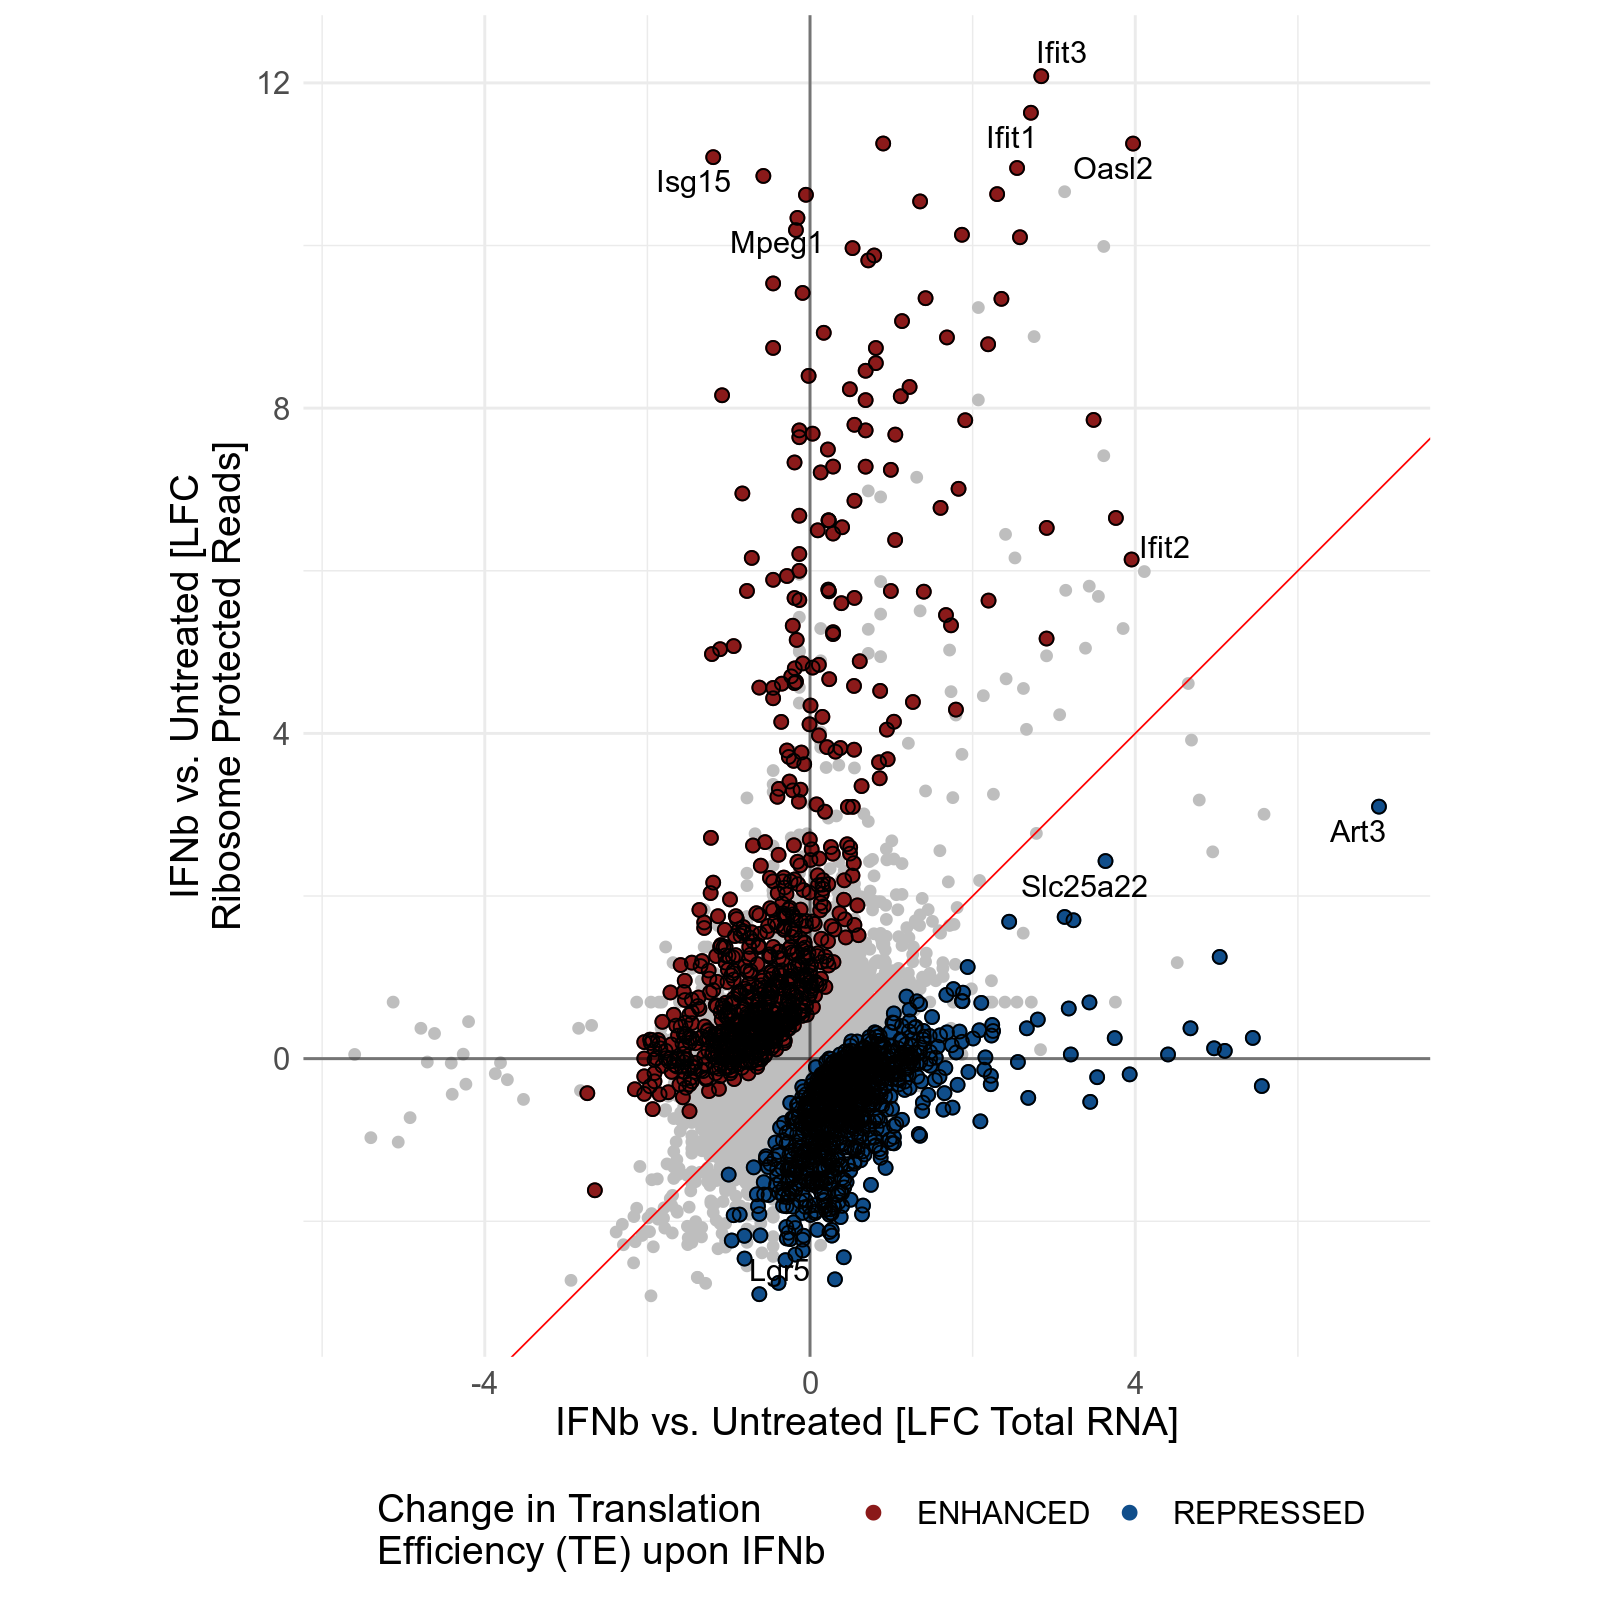

In [7]:
treatment  <- factor(rep(c('IFNb', 'untreated'), each = 4), levels = c('untreated', 'IFNb') )
replicates <- as.factor(rep(as.character(1:4), times = 2))

#identical(names(symbolsCDS), rownames(ribobCDScounts) )

foot <- as_tibble(log2(ribobCDScounts + 1))
colnames(foot) <- paste0(treatment, '_', replicates)
total <- as_tibble(log2(totalGenecounts + 1))
colnames(total) <- paste0(treatment, '_', replicates)

total_sub     <- totalGenecounts[names(symbolsCDS), ]
both_detected <- (rowSums(ribobCDScounts) > 0)  & (rowSums(total_sub) > 0) # be stricter with threshold
both_detected['ENSMUSG00000074637'] <- TRUE 
assayCount    <- cbind(ribobCDScounts[both_detected, ], (total_sub[both_detected, ])) 

total_ifnb <- rowMeans(total_sub[both_detected, 1:4])
total_untr <- rowMeans(total_sub[both_detected, 5:8])
#toCDS_ifnb <- rowMeans( totalCDScounts[names(both_detected)[both_detected], 1:4]  )
#toCDS_untr <- rowMeans( totalCDScounts[names(both_detected)[both_detected], 5:8]  )
ribob_ifnb <- rowMeans(ribobCDScounts[both_detected, 1:4])
ribob_untr <- rowMeans(ribobCDScounts[both_detected, 5:8])

dds2 <- DESeqDataSetFromMatrix(
    countData = assayCount,
    colData = tibble(assay = rep(c('Footprints', 'Total_RNA'), each = 8), treatment = rep(treatment, 2)),
    design = ~ assay + treatment + assay:treatment
)

dds2 <- DESeq(dds2, reduced = ~ assay + treatment, test = 'LRT', quiet = TRUE, fitType = 'local')
res2 <- results(dds2)@listData 
dwn  <- which(res2$padj < .1 & res2$log2FoldChange > 0) 
upr  <- which(res2$padj < .1 & res2$log2FoldChange < 0) 
te_mode <- rep('n.s.', length(res2$pvalue) )
te_mode[dwn] <- 'REPRESSED'
te_mode[upr] <- 'ENHANCED'

df_ <- tibble( Footprints_Untreated = ribob_untr + 1,
               Footprints_IFNb      = ribob_ifnb + 1,
               Total_RNA_Untreated  = total_untr + 1,
               Total_RNA_IFNb       = total_ifnb + 1
               #TE_Mode              = te_mode
               )
df_ <- apply(df_, 1, function(x, y){ x/y }, y = colSums(df_)/mean(colSums(df_)) ) %>% t() %>% as.tibble()
df_ <- cbind(df_, TE_Mode = te_mode)
length(dwn)
length(upr)
ifn_te_14h_down <- names(symbolsCDS)[both_detected][dwn]
ifn_te_14h_up <- names(symbolsCDS)[both_detected][upr]
df__ <- cbind(df_, Symbol = symbolsCDS[both_detected], ENSG = names(symbolsCDS)[both_detected] ) %>% as_tibble()
#df__
df_$Gene <- symbolsCDS[both_detected]

gg_te_scat <-  ggplot( filter(df_, TE_Mode == 'n.s.' ), aes(
  x= log2(Total_RNA_IFNb/Total_RNA_Untreated),
  y= log2(Footprints_IFNb/Footprints_Untreated),
  label = Gene
  )) + geom_point(size = 1.5, colour = 'grey') +
  geom_point(data = filter(df_, TE_Mode != 'n.s.' ), aes(colour = TE_Mode), size = 2 ) +
  geom_point(data = filter(df_, TE_Mode != 'n.s.' ), color = 'black', shape = 1, size = 2 ) +
  geom_text_repel(data = filter(df_, Gene %in% c('Oasl2', 'Ifit2', 'Ifit1', 'Ifit3', 'Mpeg1', 'Isg15', 'Lgr5', 'Slc25a22', 'Art3') )  ) +
  #geom_abline(slope = 1, intercept = 0) +
  theme_minimal() +
  scale_colour_manual(values = c('firebrick4', 'dodgerblue4')) +
  geom_abline( slope = 1, intercept =  0, size = .3, color = 'red') +
  geom_hline(yintercept = 0, alpha = 0.5) +
  geom_vline(xintercept = 0, alpha = 0.5) +
  theme(legend.position = 'bottom', text = element_text(size = 14)) +
  labs(x = 'TE(untreated)', y = 'TE(IFNb treated)') +
  coord_equal() +
  labs(x = 'IFNb vs. Untreated [LFC Total RNA]',
       y = 'IFNb vs. Untreated [LFC\nRibosome Protected Reads]',
       color = 'Change in Translation\nEfficiency (TE) upon IFNb'
       )
gg_te_scat

## Figure 2E (TOP mRNAs after 2h IFN)


FALSE  TRUE 
15392    64 

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 262 rows containing missing values (geom_point).”
Warning message:
“Removed 262 rows containing missing values (geom_point).”


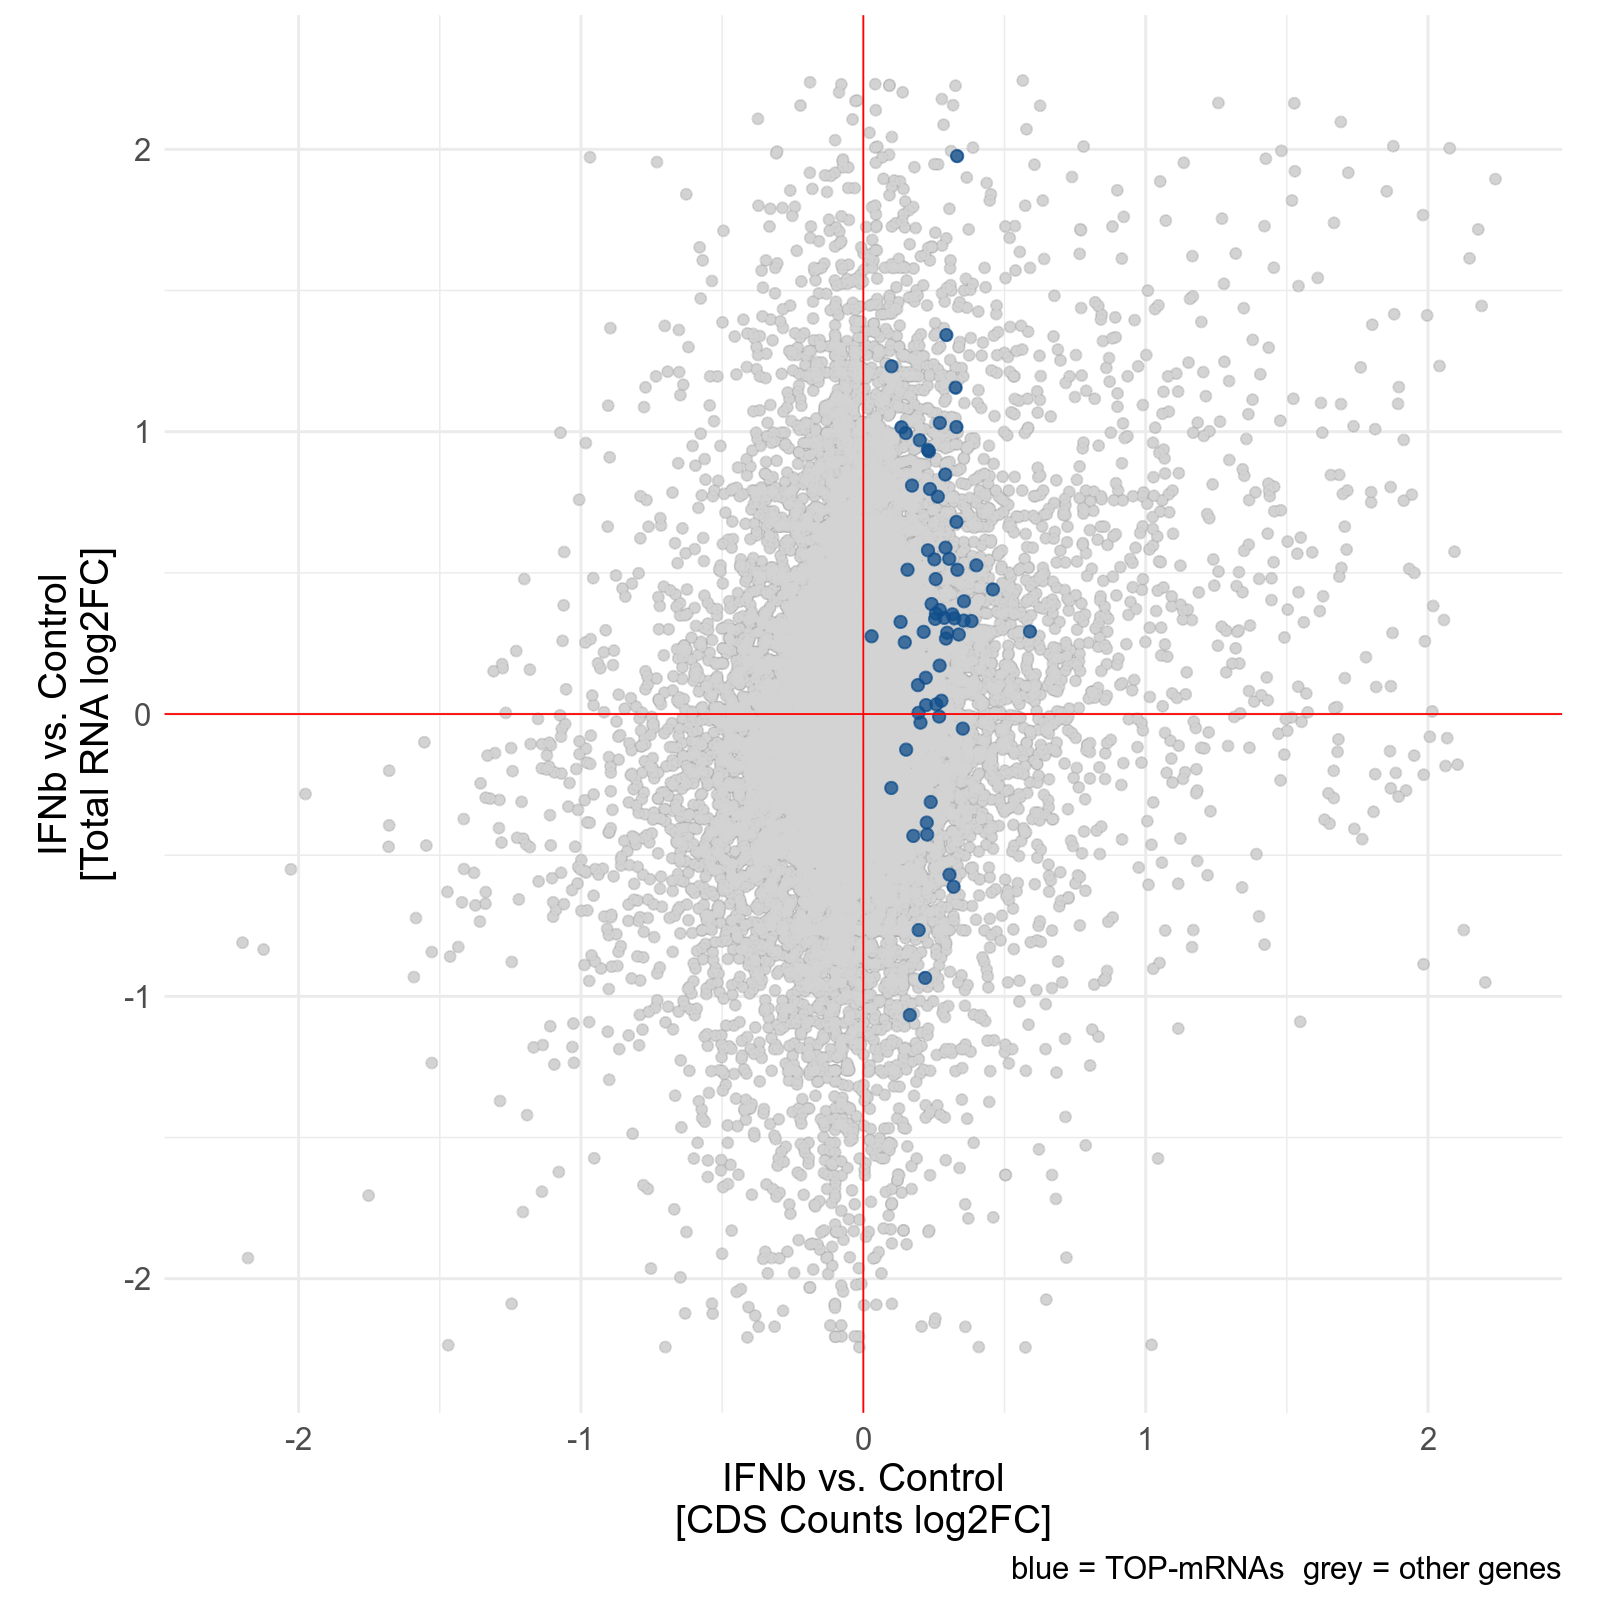

In [8]:
nrm_counts <- counts( dds2_2h, normalized=TRUE)
df_ <- tibble(
        Footprints_IFNb = rowMeans( nrm_counts[ ,1:4] ) + 1,
        Total_RNA_IFNb  = rowMeans( nrm_counts[ ,9:12] ) + 1 ,
        Footprints_Untreated = rowMeans( nrm_counts[ ,5:8] ) + 1,
        Total_RNA_Untreated  = rowMeans( nrm_counts[ ,13:16] ) + 1
       )

df_top <- cbind(df_, top = symbolsCDS[rownames(assayCount_2h)] %in% top_mrna)
table(df_top$top)

gg_top_scat <-  ggplot( df_top, aes(colour = as.factor(top),
  x= log2(Footprints_IFNb/Footprints_Untreated),
  y= log2(Total_RNA_IFNb/Total_RNA_Untreated)  )) + 
  theme_minimal() +
    geom_point(alpha = .5) + xlim(c(-2.25, 2.25)) + ylim(c(-2.25, 2.25)) +
    guides(color = FALSE) +
    scale_color_manual(values = c('darkgrey', 'dodgerblue4') ) +
      geom_point(colour = 'lightgrey',  size = 1,  alpha = .75) +
    geom_point(data = filter(df_top, top), colour = 'dodgerblue4',  size = 1.75,  alpha = .75) +
    theme(legend.position = 'bottom', text = element_text(size = 14)) +
  labs(x = 'IFNb vs. Control\n[CDS Counts log2FC]',
       y = 'IFNb vs. Control\n[Total RNA log2FC]',
       caption = 'blue = TOP-mRNAs  grey = other genes') +
    geom_hline(yintercept = 0, col = 'red', size = .3) +
  geom_vline(xintercept = 0, col = 'red', size = .3) +
  coord_equal()
  
gg_top_scat

## Figure 2F (TOP mRNAs after 14h IFN)


FALSE  TRUE 
15480    63 

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 503 rows containing missing values (geom_point).”
Warning message:
“Removed 503 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


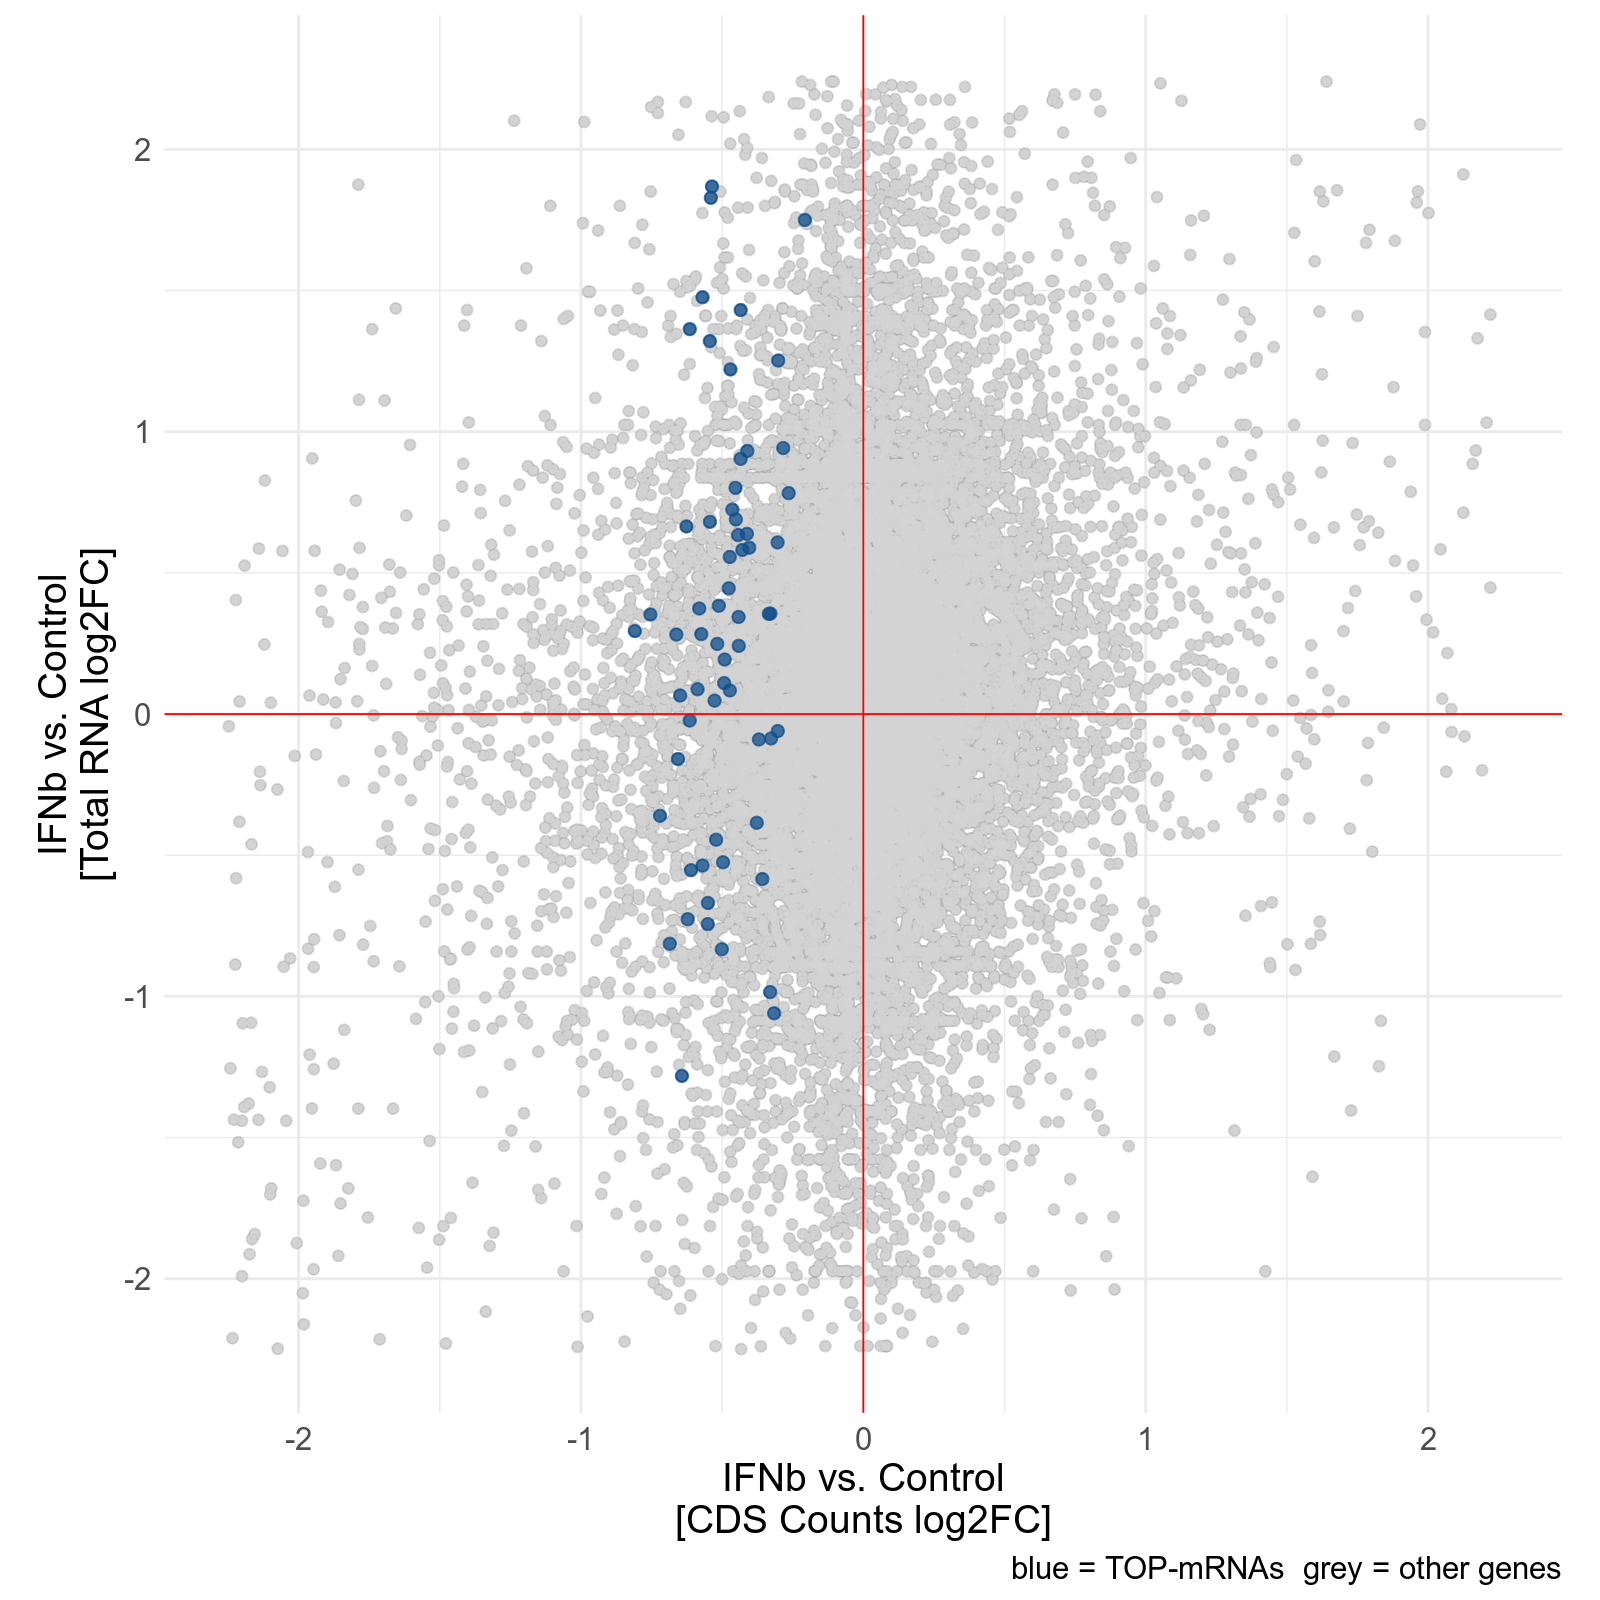

In [9]:
nrm_counts <- counts( dds2, normalized=TRUE)
df_ <- tibble(
        Footprints_IFNb = rowMeans( nrm_counts[ ,1:4] ) + 1,
        Total_RNA_IFNb  = rowMeans( nrm_counts[ ,9:12] ) + 1 ,
        Footprints_Untreated = rowMeans( nrm_counts[ ,5:8] ) + 1,
        Total_RNA_Untreated  = rowMeans( nrm_counts[ ,13:16] ) + 1
       )

df_top <- cbind(df_, top = symbolsCDS[rownames(assayCount)] %in% top_mrna)
table(df_top$top)

gg_top_scat <-  ggplot( df_top, aes(colour = as.factor(top),
  x= log2(Footprints_IFNb/Footprints_Untreated),
  y= log2(Total_RNA_IFNb/Total_RNA_Untreated)  )) + 
  theme_minimal() +
    geom_point(alpha = .5) + xlim(c(-2.25, 2.25)) + ylim(c(-2.25, 2.25)) +
    guides(color = FALSE) +
    scale_color_manual(values = c('darkgrey', 'dodgerblue4') ) +
      geom_point(colour = 'lightgrey',  size = 1,  alpha = .75) +
    geom_point(data = filter(df_top, top), colour = 'dodgerblue4',  size = 1.75,  alpha = .75) +
    theme(legend.position = 'bottom', text = element_text(size = 14)) +
  labs(x = 'IFNb vs. Control\n[CDS Counts log2FC]',
       y = 'IFNb vs. Control\n[Total RNA log2FC]',
       caption = 'blue = TOP-mRNAs  grey = other genes') +
    geom_hline(yintercept = 0, col = 'red', size = .3) +
  geom_vline(xintercept = 0, col = 'red', size = .3) +
  coord_equal()
  
gg_top_scat

## Supplemental figures: GSEA

Please note that GSEA analyses will give different results depending on the state of the random number generator. Unfortunately we do not know the state of Manuel Göpferich's random number generator when the figure was generated.

This means that while the results you get _should_ be the results from the paper, the specific values and terms deemed significant can vary from run to run.

In [10]:
total_2h_ifn <- totalGenecounts_2h[names(symbolsCDS), 1:4] %>% rowMeans() + 1
total_14_ifn <- totalGenecounts[names(symbolsCDS), 1:4] %>% rowMeans() + 1
ribob_2h_ifn <- ribobCDScounts_2h[names(symbolsCDS), 1:4] %>% rowMeans() + 1
ribob_14_ifn <- ribobCDScounts[names(symbolsCDS), 1:4] %>% rowMeans() + 1

total_2h_ctl <- totalGenecounts_2h[names(symbolsCDS), 5:8] %>% rowMeans() + 1
total_14_ctl <- totalGenecounts[names(symbolsCDS), 5:8] %>% rowMeans() + 1
ribob_2h_ctl <- ribobCDScounts_2h[names(symbolsCDS), 5:8] %>% rowMeans() + 1
ribob_14_ctl <- ribobCDScounts[names(symbolsCDS), 5:8] %>% rowMeans() + 1

master_idx <- rowMeans(ribobCDScounts_2h) > 4 & rowMeans(ribobCDScounts_2h) > 4

# average both scores

te_2h <- log2(ribob_2h_ifn/total_2h_ifn)-log2(ribob_2h_ctl/total_2h_ctl)
te_2h <- te_2h - median(te_2h)

te_14h <- log2(ribob_14_ifn/total_14_ifn)-log2(ribob_14_ctl/total_14_ctl)
te_14h <- te_14h - median(te_14h)

# plot plus a shiny, plottly ?

double_tbl <- tibble( TE_Change_2h = te_2h,
                      TE_Change_14h =te_14h,
                      total_2h_ifn = total_2h_ifn, 
                      total_14_ifn = total_14_ifn, 
                      ribob_2h_ifn = ribob_2h_ifn,
                      ribob_14_ifn = ribob_14_ifn, 
                      total_2h_ctl = total_2h_ctl, 
                      total_14_ctl = total_14_ctl, 
                      ribob_2h_ctl = ribob_2h_ctl,
                      ribob_14_ctl = ribob_14_ctl,
                      ExpressionIdx = master_idx,
                      Gene = names( symbolsCDS ),
                      Symbols = symbolsCDS )

### Figure S2A (GSEA on TE after 2h IFN)

In [11]:
GO_TERMS_2h <- c(
    "electron transport chain",
    "ribonucleotide metabolic process",
    "positive regulation of cell cycle process",
    "tyrosine phosphorylation of STAT protein",
    "inflammatory response",
    "cytokine production",
    "immune effector process",
    "defense response to virus",
    "response to interferon-beta"
)

Loading required package: org.Mm.eg.db



preparing geneSet collections...

GSEA analysis...

Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (0.82% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



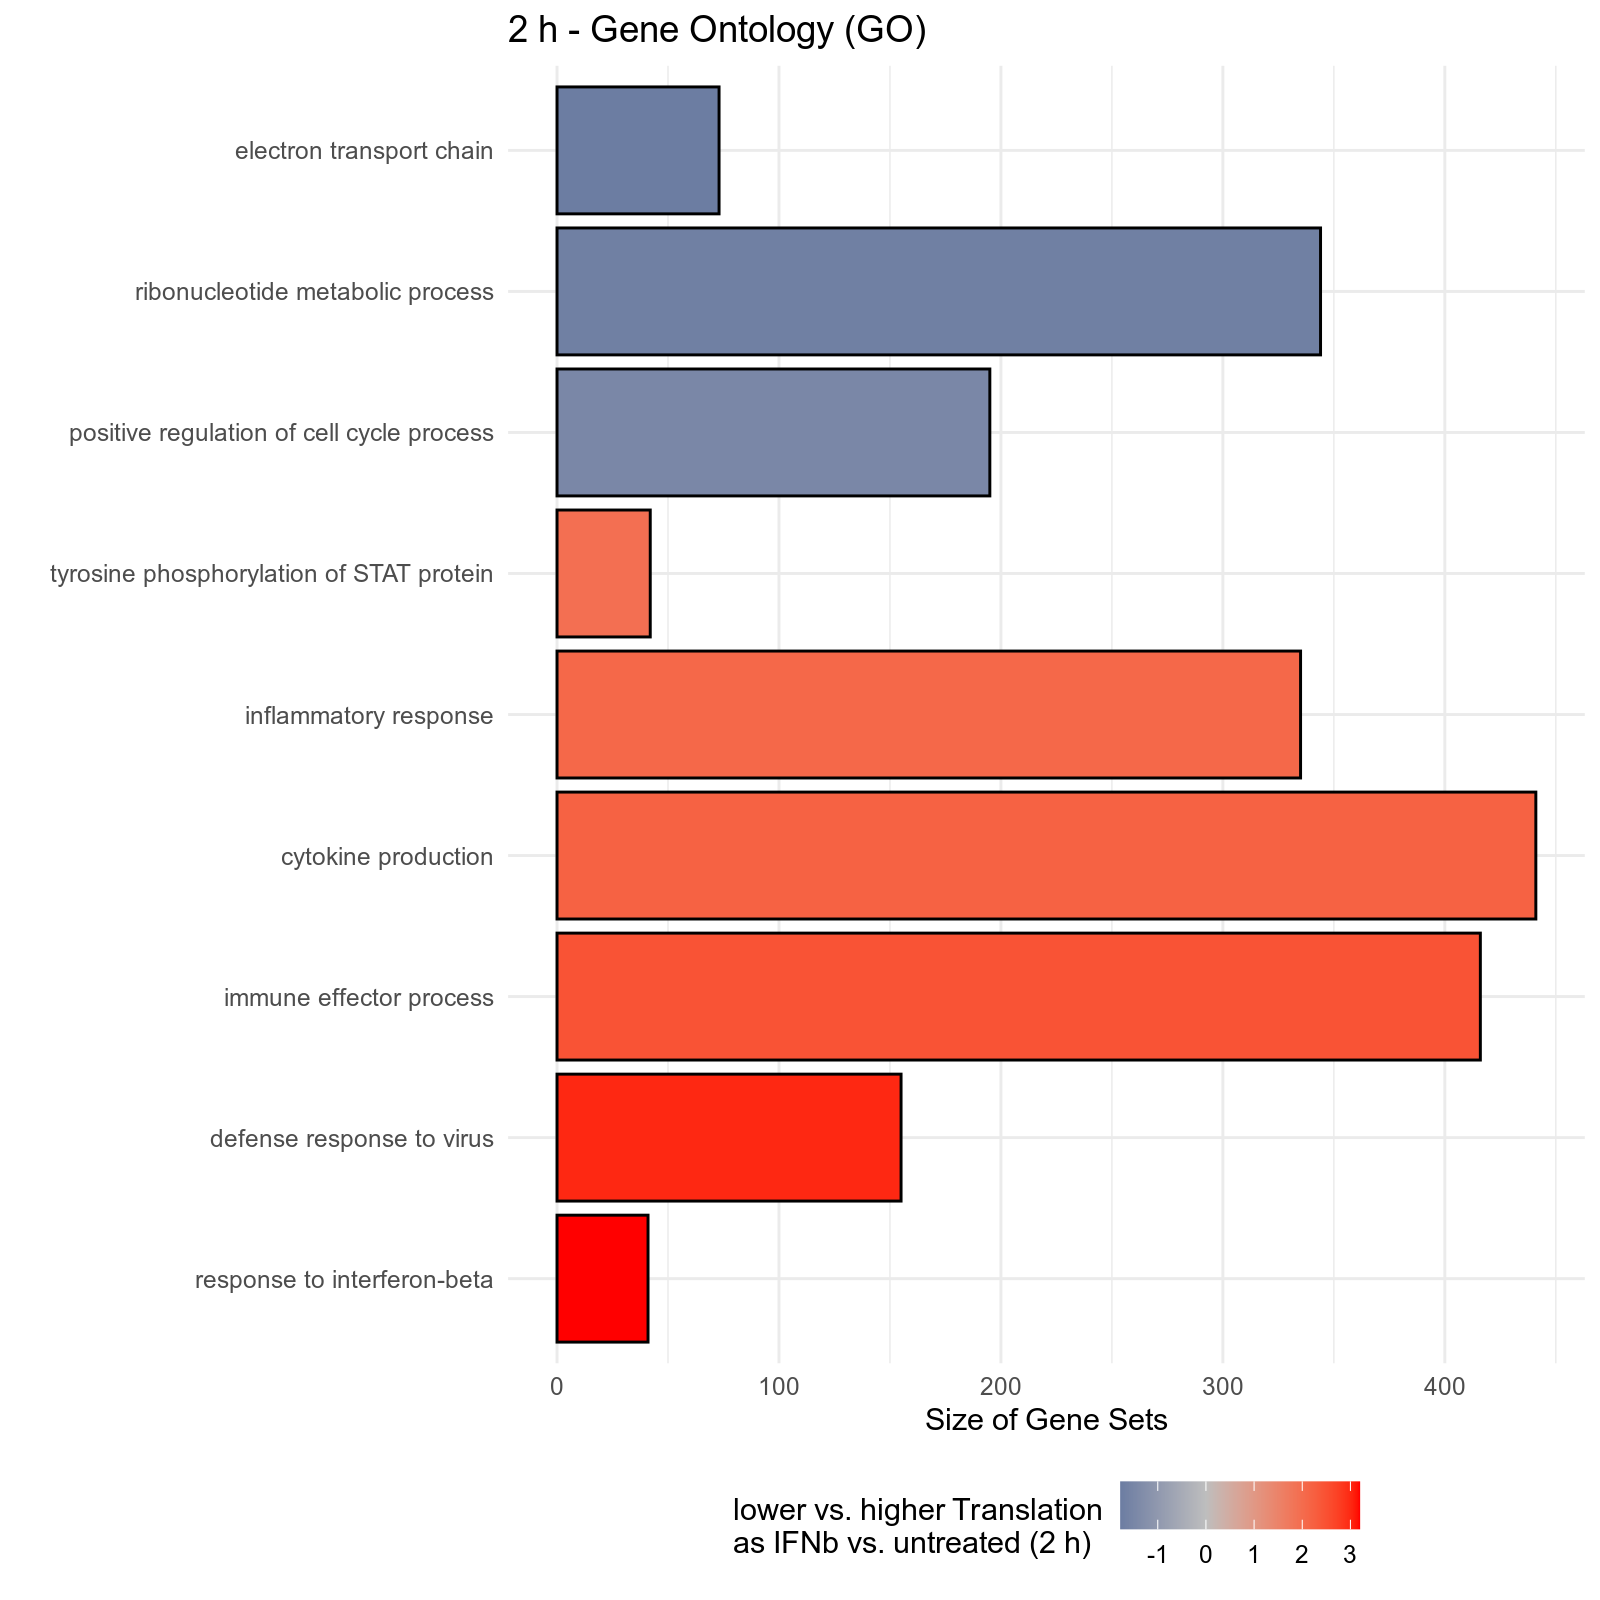

In [12]:
dbl <- filter(double_tbl, ExpressionIdx)
score <- dbl$TE_Change_2h
names(score) <- dbl$Gene
score <- sort(score, decreasing = TRUE)
require(org.Mm.eg.db)
res <- gseGO(score, keyType = 'ENSEMBL', OrgDb = org.Mm.eg.db, nPerm=10000, pvalueCutoff=0.1)

gsl_sub <- res@result %>%
    filter(Description %in% GO_TERMS_2h)
#gsl_sub <- res@result[ c(1, 4, 8, 15, 25, 135, 158, 164, 111 ) , ]
gsl_sub <- mutate(gsl_sub, Description = factor(Description, levels = Description[order(NES, decreasing = T)] ) )

f1g <- ggplot( gsl_sub, aes(y = setSize, x = Description, fill = NES ) ) +
           geom_col(color='black') + coord_flip() + ggtitle('2 h - Gene Ontology (GO)') +
           theme_minimal() +
           labs(x = '', y = 'Size of Gene Sets') +
           scale_fill_gradient2( mid = 'grey', low = 'dodgerblue4', high = 'red', midpoint = 0 ) +
           theme(legend.position = 'bottom') + 
           labs(fill = 'lower vs. higher Translation\nas IFNb vs. untreated (2 h)')

f1g

### Figure S2B (GSEA on TE after 14h IFN)

In [13]:
GO_TERMS_14h <- c(
    "DNA replication",
    "remobinational repair",
    "G2/M transition of mitotic cell cycle",
    "DNA repair",
    "cell cycle checkpoint",
    "cytokine production",
    "positive regulation of cytokine production",
    "immune effector process",
    "response to interferon-beta",
    "response to virus"
)

preparing geneSet collections...

GSEA analysis...

Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“There are ties in the preranked stats (1.51% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



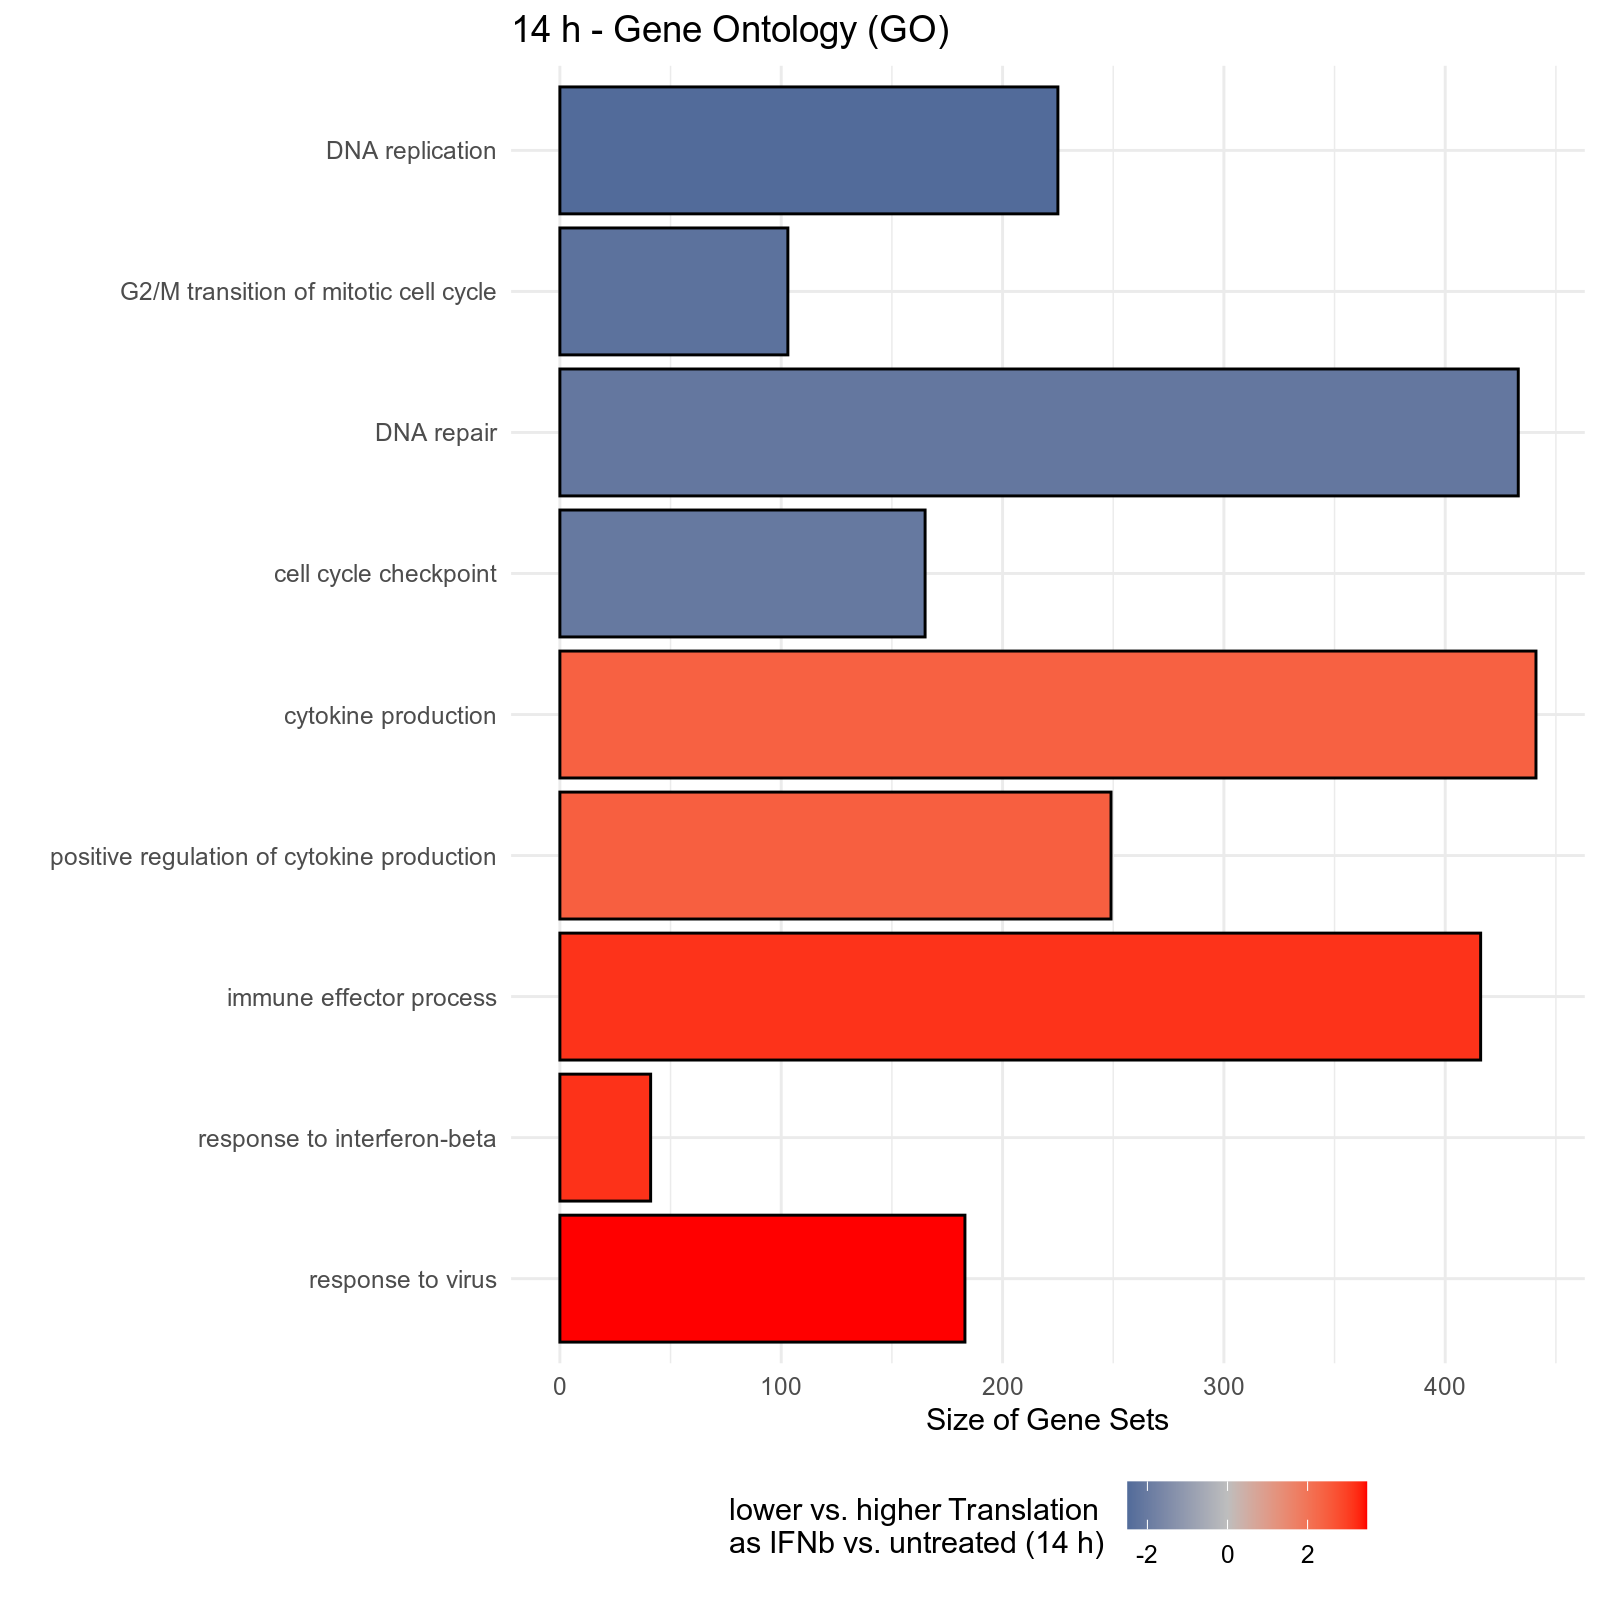

In [14]:
dbl <- filter(double_tbl, ExpressionIdx)
score <- dbl$TE_Change_14h
names(score) <- dbl$Gene
score <- sort(score, decreasing = TRUE)
require(org.Mm.eg.db)
res <- gseGO(score, keyType = 'ENSEMBL', OrgDb = org.Mm.eg.db, nPerm=10000, pvalueCutoff=0.1)

#gsl_sub <- res@result[ c(1, 4, 8, 15, 25, 135, 158, 164, 111 ) , ]
gsl_sub <- res@result %>%
    filter(Description %in% GO_TERMS_14h)
gsl_sub <- mutate(gsl_sub, Description = factor(Description, levels = Description[order(NES, decreasing = T)] ) )

f1g <- ggplot( gsl_sub, aes(y = setSize, x = Description, fill = NES ) ) +
           geom_col(color='black') + coord_flip() + ggtitle('14 h - Gene Ontology (GO)') +
           theme_minimal() +
           labs(x = '', y = 'Size of Gene Sets') +
           scale_fill_gradient2( mid = 'grey', low = 'dodgerblue4', high = 'red', midpoint = 0 ) +
           theme(legend.position = 'bottom') + 
           labs(fill = 'lower vs. higher Translation\nas IFNb vs. untreated (14 h)')

f1g

# End

In [15]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Arch Linux

Matrix products: default
BLAS/LAPACK: /home/jooa/.conda/envs/riboseq/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_DK.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_DK.UTF-8        LC_COLLATE=en_DK.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_DK.UTF-8   
 [7] LC_PAPER=en_DK.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_DK.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Mm.eg.db_3.10.0                   
 [2] clusterProfiler_3.14.3                
 [3] biomaRt_2.42.1                        
 [4] ggrepel_0.9.1                         
 [5] gridExtra_2.3                         
 [6] DESeq2_1.26.0                         
 [7] forcats_0.5.1            